# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt

import gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The next cells contain instructions for downloading data.
**Please, make your own copy.**

In [ ]:
#data
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
#dates
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE

Downloading...
From: https://drive.google.com/uc?id=1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
To: /content/x_test_night.npy
100% 58.7M/58.7M [00:00<00:00, 118MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
From (redirected): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY&confirm=t&uuid=53eed327-1493-4831-8d93-d87a65ae69c2
To: /content/x_train_night.npy
100% 382M/382M [00:02<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
To: /content/x_val_night.npy
100% 71.4M/71.4M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
To: /content/dates_test_night.npy
100% 3.71k/3.71k [00:00<00:00, 16.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
To: /content/dates_train_night.npy
100% 23.5k/23.5k [00:00<00:00, 52.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hGg-J7ipuil

In [ ]:
#land-sea mask
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK

Downloading...
From: https://drive.google.com/uc?id=1F0GGmrrGtSHizdf0COyHErNqMf9FazCK
To: /content/land_sea_mask.npy
100% 16.5k/16.5k [00:00<00:00, 40.0MB/s]


In [ ]:
#a statistical baseline
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ

Downloading...
From: https://drive.google.com/uc?id=1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ
To: /content/stat_baseline.npy
100% 48.0M/48.0M [00:00<00:00, 114MB/s]


Le us inspect and visualize data.

In [ ]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

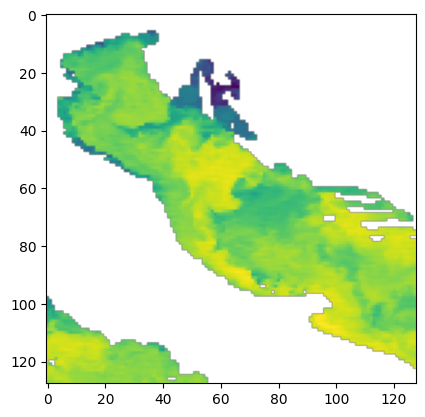

In [ ]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [ ]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


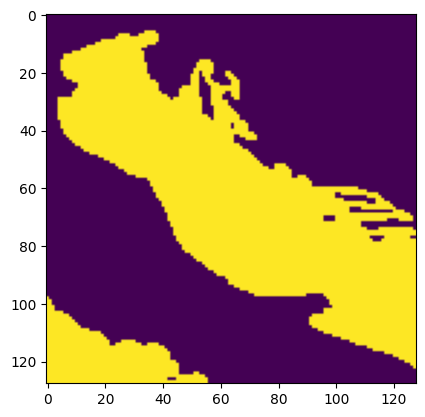

In [ ]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [ ]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


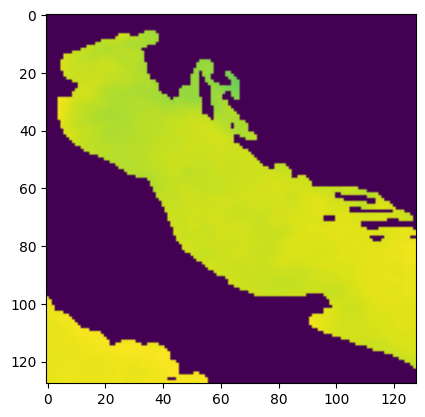

In [ ]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [ ]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [ ]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [ ]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [ ]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [ ]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 16.694999600086106
image 0; 0.0, 16.694999600086106
image 1; 0.0, 16.694999600086106
image 2; 0.0, 16.668500873210935


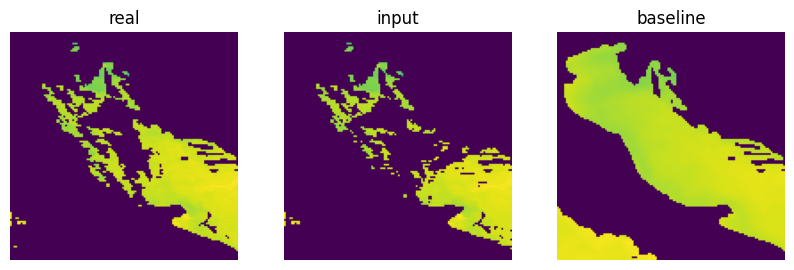

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


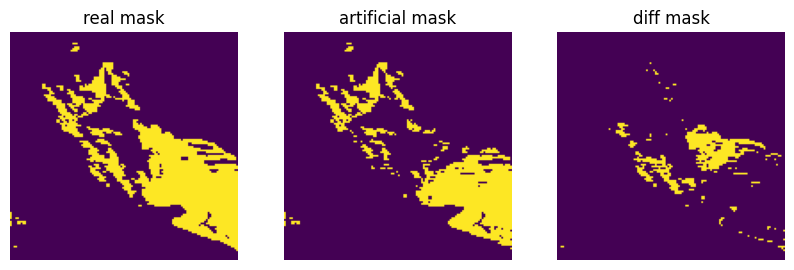

In [ ]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6357878971489037
RMSE std : 0.1976047307928983


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


#Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def attention_gate(input_g, input_x, inter_channels):
    # Linear transformations for gating signal and skip connection
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(input_x)
    phi_g = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(input_g)

    # Add the transformed feature maps
    add_xg = layers.Add()([theta_x, phi_g])
    add_xg = layers.Activation('relu')(add_xg)

    # Attention coefficients
    psi = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(add_xg)
    psi = layers.Activation('sigmoid')(psi)

    output = layers.Multiply()([input_x, psi])
    return output

In [ ]:
def unet_model(input_shape=(128, 128, 4)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    # Block 1
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization(dtype='float32')(conv1)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    x = layers.BatchNormalization(dtype='float32')(conv2)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    x = layers.BatchNormalization(dtype='float32')(conv3)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(pool3)
    x = layers.BatchNormalization(dtype='float32')(conv4)
    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv4)

    # Decoder with Attention Gates
    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(conv4)
    att1 = attention_gate(up1, conv3, inter_channels=256)  # Attention Gate
    concat1 = layers.concatenate([up1, att1])
    conv5 = layers.Conv2D(256, 3, activation="relu", padding="same")(concat1)
    x = layers.BatchNormalization(dtype='float32')(conv5)
    conv5 = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv5)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(conv5)
    att2 = attention_gate(up2, conv2, inter_channels=128)  # Attention Gate
    concat2 = layers.concatenate([up2, att2])
    conv6 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat2)
    x = layers.BatchNormalization(dtype='float32')(conv6)
    conv6 = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv6)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(conv6)
    att3 = attention_gate(up3, conv1, inter_channels=64)  # Attention Gate
    concat3 = layers.concatenate([up3, att3])
    conv7 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat3)
    x = layers.BatchNormalization(dtype='float32')(conv7)
    conv7 = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization(dtype='float32')(conv7)

    outputs = layers.Conv2D(1, 1, activation="linear")(x)

    model = Model(inputs, outputs)
    return model

model = unet_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 128, 128, 64)   │          2,368 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 128, 128, 64)   │            256 │ conv2d_93[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 128, 128, 64)   │            256 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 64, 64, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 64, 64, 128)    │            512 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 64, 64, 128)    │            512 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 32, 32, 128)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 32, 32, 256)    │          1,024 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 32, 32, 256)    │          1,024 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,878,980 (30.06 MB)

 Trainable params: 7,875,140 (30.04 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
steps_per_epoch = 100
validation_steps = 20
epochs = 100

def weighted_huber_loss(y_true, y_pred, delta=1.0):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute the error for channel 0 (SST) and squeeze y_pred to remove channel dimension.
    error = y_true[..., 0] - tf.squeeze(y_pred, axis=-1)
    abs_error = tf.abs(error)

    # Compute Huber loss per pixel.
    quadratic = 0.5 * tf.square(error)
    linear = delta * (abs_error - 0.5 * delta)
    huber_loss = tf.where(abs_error <= delta, quadratic, linear)

    # Weight the loss using the diff mask (channel 2 in y_true)
    weighted_loss = huber_loss * y_true[..., 2]

    return tf.reduce_mean(weighted_loss)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Deep_Sep/best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=lambda y_true, y_pred: weighted_huber_loss(y_true, y_pred, delta=1.0), metrics=['mae'])

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.0279 - mae: 0.6610
Epoch 1: val_loss improved from inf to 0.07854, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 427ms/step - loss: 0.0278 - mae: 0.6604 - val_loss: 0.0785 - val_mae: 0.3098 - learning_rate: 1.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 0.0044 - mae: 0.5640
Epoch 2: val_loss improved from 0.07854 to 0.04131, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - loss: 0.0044 - mae: 0.5640 - val_loss: 0.0413 - val_mae: 0.3089 - learning_rate: 1.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.0034 - mae: 0.5566
Epoch 3: val_loss improved from 0.04131 to 0.01904, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 820ms/step - loss: 0.0034 - mae: 0.5566 - val_loss: 0.0190 - val_mae: 0.3494 - learning_rate: 1.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.0028 - mae: 0.5557
Epoch 4: val_loss improved from 0.01904 to 0.00882, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - loss: 0.0028 - mae: 0.5557 - val_loss: 0.0088 - val_mae: 0.4064 - learning_rate: 1.0000e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.0028 - mae: 0.5620
Epoch 5: val_loss improved from 0.00882 to 0.00509, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 824ms/step - loss: 0.0028 - mae: 0.5620 - val_loss: 0.0051 - val_mae: 0.4787 - learning_rate: 1.0000e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.0026 - mae: 0.5546
Epoch 6: val_loss improved from 0.00509 to 0.00296, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 820ms/step - loss: 0.0026 - mae: 0.5546 - val_loss: 0.0030 - val_mae: 0.4901 - learning_rate: 1.0000e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 0.0026 - mae: 0.5446
Epoch 7: val_loss improved from 0.00296 to 0.00222, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 823ms/step - loss: 0.0026 - mae: 0.5446 - val_loss: 0.0022 - val_mae: 0.5527 - learning_rate: 1.0000e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 0.0024 - mae: 0.5596
Epoch 8: val_loss improved from 0.00222 to 0.00187, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 823ms/step - loss: 0.0024 - mae: 0.5595 - val_loss: 0.0019 - val_mae: 0.5626 - learning_rate: 1.0000e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 0.0024 - mae: 0.5514
Epoch 9: val_loss improved from 0.00187 to 0.00183, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - loss: 0.0024 - mae: 0.5514 - val_loss: 0.0018 - val_mae: 0.5474 - learning_rate: 1.0000e-04
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - loss: 0.0023 - mae: 0.5570
Epoch 10: val_loss did not improve from 0.00183
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 804ms/step - loss: 0.0023 - mae: 0.5570 - val_loss: 0.0019 - val_mae: 0.5705 - learning_rate: 1.0000e-04
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 0.0022 - mae: 0.5536
Epoch 11: val_loss improved from 0.00183 to 0.00178, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 425ms/step - loss: 0.0022 - mae: 0.5536 - val_loss: 0.0018 - val_mae: 0.5672 - learning_rate: 1.0000e-04
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.0021 - mae: 0.5520
Epoch 12: val_loss improved from 0.00178 to 0.00175, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 436ms/step - loss: 0.0021 - mae: 0.5520 - val_loss: 0.0017 - val_mae: 0.5335 - learning_rate: 1.0000e-04
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - loss: 0.0022 - mae: 0.5472
Epoch 13: val_loss did not improve from 0.00175
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - loss: 0.0022 - mae: 0.5472 - val_loss: 0.0019 - val_mae: 0.5371 - learning_rate: 1.0000e-04
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.0022 - mae: 0.5546
Epoch 14: val_loss improved from 0.00175 to 0.00163, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 841ms/step - loss: 0.0022 - mae: 0.5545 - val_loss: 0.0016 - val_mae: 0.5501 - learning_rate: 1.0000e-04
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.0020 - mae: 0.5482
Epoch 15: val_loss did not improve from 0.00163
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 804ms/step - loss: 0.0020 - mae: 0.5482 - val_loss: 0.0017 - val_mae: 0.5140 - learning_rate: 1.0000e-04
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0019 - mae: 0.5516
Epoch 16: val_loss improved from 0.00163 to 0.00161, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - loss: 0.0019 - mae: 0.5516 - val_loss: 0.0016 - val_mae: 0.5498 - learning_rate: 1.0000e-04
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 0.0018 - mae: 0.5570
Epoch 17: val_loss did not improve from 0.00161
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - loss: 0.0018 - mae: 0.5570 - val_loss: 0.0023 - val_mae: 0.5594 - learning_rate: 1.0000e-04
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.0019 - mae: 0.5409
Epoch 18: val_loss did not improve from 0.00161
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0019 - mae: 0.5409 - val_loss: 0.0016 - val_mae: 0.5535 - learning_rate: 1.0000e-04
Epoch 19/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0018 - mae: 0.5434
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 19: val_loss improved from 0.00161 to 0.00161, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - loss: 0.0018 - mae: 0.5435 - val_loss: 0.0016 - val_mae: 0.5575 - learning_rate: 1.0000e-04
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.0017 - mae: 0.5523
Epoch 20: val_loss improved from 0.00161 to 0.00149, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 823ms/step - loss: 0.0017 - mae: 0.5523 - val_loss: 0.0015 - val_mae: 0.5614 - learning_rate: 5.0000e-05
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.0017 - mae: 0.5466
Epoch 21: val_loss did not improve from 0.00149
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 803ms/step - loss: 0.0017 - mae: 0.5467 - val_loss: 0.0015 - val_mae: 0.5364 - learning_rate: 5.0000e-05
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0017 - mae: 0.5566
Epoch 22: val_loss improved from 0.00149 to 0.00146, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 0.0017 - mae: 0.5565 - val_loss: 0.0015 - val_mae: 0.5187 - learning_rate: 5.0000e-05
Epoch 23/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0016 - mae: 0.5465
Epoch 23: val_loss improved from 0.00146 to 0.00144, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - loss: 0.0016 - mae: 0.5465 - val_loss: 0.0014 - val_mae: 0.5579 - learning_rate: 5.0000e-05
Epoch 24/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0016 - mae: 0.5467
Epoch 24: val_loss did not improve from 0.00144
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 803ms/step - loss: 0.0016 - mae: 0.5467 - val_loss: 0.0015 - val_mae: 0.5491 - learning_rate: 5.0000e-05
Epoch 25/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.0016 - mae: 0.5433
Epoch 25: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 25: val_loss did not improve from 0.00144
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0016 - mae: 0.5433 - val_loss: 0.0016 - val_mae: 0.5463 - learning_rate: 5.0000e-05
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0016 - mae: 0.5462
Epoch 26: val_loss did not improve from 0.00144
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0016 - mae: 0.5462 - val_loss: 0.0015 - val_mae: 0.5300

100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 844ms/step - loss: 0.0016 - mae: 0.5446 - val_loss: 0.0014 - val_mae: 0.5463 - learning_rate: 2.5000e-05
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0015 - mae: 0.5457
Epoch 28: val_loss improved from 0.00142 to 0.00140, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 820ms/step - loss: 0.0015 - mae: 0.5457 - val_loss: 0.0014 - val_mae: 0.5473 - learning_rate: 2.5000e-05
Epoch 29/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 0.0016 - mae: 0.5574
Epoch 29: val_loss did not improve from 0.00140
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 397ms/step - loss: 0.0016 - mae: 0.5573 - val_loss: 0.0014 - val_mae: 0.5417 - learning_rate: 2.5000e-05
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0015 - mae: 0.5455
Epoch 30: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 30: val_loss did not improve from 0.00140
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0015 - mae: 0.5456 - val_loss: 0.0015 - val_mae: 0.5554 - learning_rate: 2.5000e-05
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.0015 - mae: 0.5572
Epoch 31: val_loss improved from 0.00140 to 0.00137, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 843ms/step - loss: 0.0015 - mae: 0.5572 - val_loss: 0.0014 - val_mae: 0.5472 - learning_rate: 1.2500e-05
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.0015 - mae: 0.5500
Epoch 32: val_loss improved from 0.00137 to 0.00129, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 421ms/step - loss: 0.0015 - mae: 0.5500 - val_loss: 0.0013 - val_mae: 0.5359 - learning_rate: 1.2500e-05
Epoch 33/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0015 - mae: 0.5519
Epoch 33: val_loss did not improve from 0.00129
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 804ms/step - loss: 0.0015 - mae: 0.5520 - val_loss: 0.0015 - val_mae: 0.5210 - learning_rate: 1.2500e-05
Epoch 34/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.0015 - mae: 0.5523
Epoch 34: val_loss did not improve from 0.00129
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - loss: 0.0015 - mae: 0.5523 - val_loss: 0.0014 - val_mae: 0.5603 - learning_rate: 1.2500e-05
Epoch 35/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.0014 - mae: 0.5548
Epoch 35: val_loss did not improve from 0.00129
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 823ms/step - loss: 0.0014 - mae: 0.5548 - val_loss: 0.0014 - val_mae: 0.5540 - learning_rate: 1.2500e-05
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 374m

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - loss: 0.0014 - mae: 0.5559 - val_loss: 0.0013 - val_mae: 0.5421 - learning_rate: 6.2500e-06
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.0014 - mae: 0.5522
Epoch 42: val_loss did not improve from 0.00126
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - loss: 0.0014 - mae: 0.5522 - val_loss: 0.0014 - val_mae: 0.5454 - learning_rate: 6.2500e-06
Epoch 43/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.0015 - mae: 0.5697
Epoch 43: val_loss did not improve from 0.00126
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - loss: 0.0015 - mae: 0.5696 - val_loss: 0.0013 - val_mae: 0.5606 - learning_rate: 6.2500e-06
Epoch 44/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.0014 - mae: 0.5574
Epoch 44: val_loss did not improve from 0.00126
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 0.0014 - mae: 0.5574 - val_loss: 0.0013 - val_mae: 0.5208 - learning_rate: 6.2500e-06
Epoch 45/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 392m

##Evaluate the Model

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model.predict(batch_x, verbose=0)[..., 0]

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.5254346242898691
RMSE std : 0.14714434738642257


##Visualize Model

In [ ]:
!pip install visualkeras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 23.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


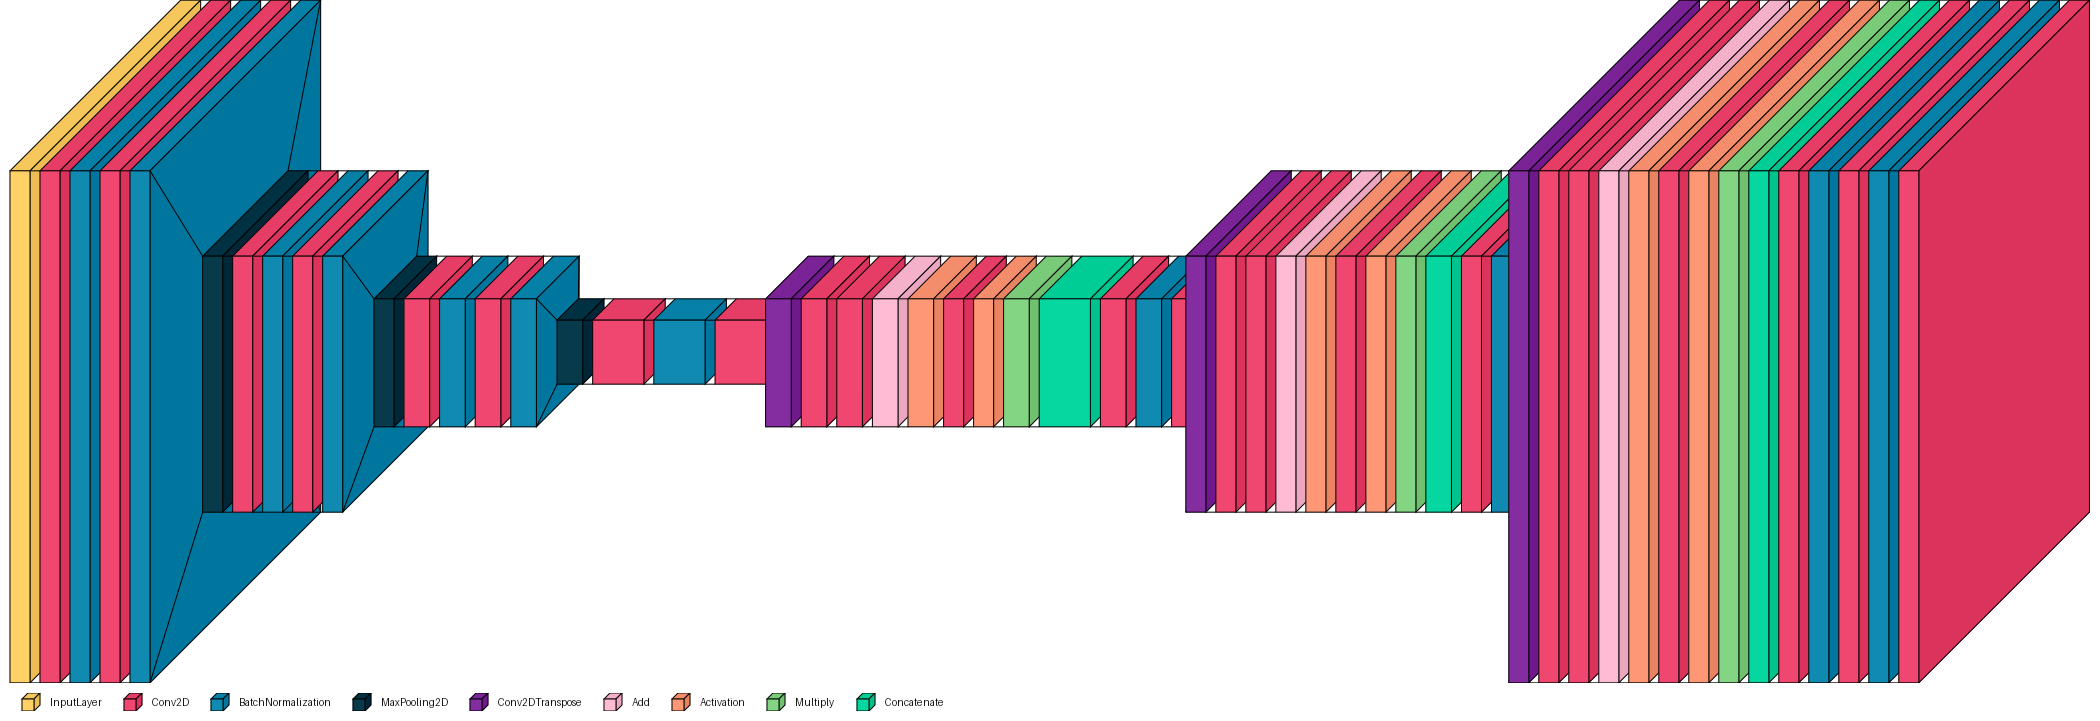

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True)

In [ ]:
model.load_weights('/content/drive/MyDrive/Projects/Deep_Sep/best_model.h5')

#Visual Transformer

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Layer to extract patches from the input image.
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Layer to encode patches by projecting them to a latent space and adding positional embeddings.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# Transformer block with multi-head self-attention and feed-forward network.
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'),
             layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build a Visual Transformer model for SST reconstruction.
def vit_model(
    input_shape=(128, 128, 4),
    patch_size=16,
    num_layers=4,
    projection_dim=256,
    num_heads=4,
    ff_dim=512,
    dropout_rate=0.1,
):
    inputs = layers.Input(shape=input_shape)

    # 1. Extract patches from the input image.
    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # 2. Encode the patches with a linear projection and positional embeddings.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # 3. Process the patch embeddings with a series of transformer blocks.
    for _ in range(num_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, ff_dim, dropout_rate)(encoded_patches)

    # 4. Reshape the sequence of embeddings back to a 2D feature map.
    patch_dim = input_shape[0] // patch_size  # Assumes square input.
    x = layers.Reshape((patch_dim, patch_dim, projection_dim))(encoded_patches)

    # 5. Decoder: Upsample to the original resolution.
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    # In case the upsampling overshoots the original size, you can add a cropping layer or adjust strides.
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    # 6. Final convolution to produce a single-channel SST reconstruction.
    outputs = layers.Conv2D(1, 1, activation="linear")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model.
model_vit = vit_model()
model_vit.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 128, 128, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patches (Patches)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder (PatchEncoder)         │ (None, 64, 256)             │         278,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 64, 256)             │       1,315,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 64, 256)             │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ (None, 64, 256)             │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 64, 256)             │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 16, 16, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 32, 32, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 64, 64, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 128, 128, 16)        │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_121 (Conv2D)                  │ (None, 128, 128, 1)         │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,934,081 (22.64 MB)

 Trainable params: 5,934,081 (22.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
steps_per_epoch = 100
validation_steps = 20
epochs = 50

def weighted_huber_loss(y_true, y_pred, delta=1.0):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute the error for channel 0 (SST) and squeeze y_pred to remove channel dimension.
    error = y_true[..., 0] - tf.squeeze(y_pred, axis=-1)
    abs_error = tf.abs(error)

    # Compute Huber loss per pixel.
    quadratic = 0.5 * tf.square(error)
    linear = delta * (abs_error - 0.5 * delta)
    huber_loss = tf.where(abs_error <= delta, quadratic, linear)

    # Weight the loss using the diff mask (channel 2 in y_true)
    weighted_loss = huber_loss * y_true[..., 2]

    return tf.reduce_mean(weighted_loss)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Deep_Sep/best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=lambda y_true, y_pred: weighted_huber_loss(y_true, y_pred, delta=1.0), metrics=['mae'])

history = model_vit.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0826 - mae: 0.3928
Epoch 1: val_loss improved from inf to 0.05620, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - loss: 0.0825 - mae: 0.3938 - val_loss: 0.0562 - val_mae: 0.6579 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0524 - mae: 0.6420
Epoch 2: val_loss improved from 0.05620 to 0.05024, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0524 - mae: 0.6421 - val_loss: 0.0502 - val_mae: 0.6723 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0311 - mae: 0.6975
Epoch 3: val_loss improved from 0.05024 to 0.00426, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0310 - mae: 0.6979 - val_loss: 0.0043 - val_mae: 0.9127 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0034 - mae: 0.7979
Epoch 4: val_loss improved from 0.00426 to 0.00247, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0034 - mae: 0.7978 - val_loss: 0.0025 - val_mae: 0.8146 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0029 - mae: 0.8020
Epoch 5: val_loss improved from 0.00247 to 0.00243, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0029 - mae: 0.8020 - val_loss: 0.0024 - val_mae: 0.8662 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0028 - mae: 0.7914
Epoch 6: val_loss improved from 0.00243 to 0.00243, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.0028 - mae: 0.7914 - val_loss: 0.0024 - val_mae: 0.8583 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0025 - mae: 0.7965
Epoch 7: val_loss did not improve from 0.00243
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0025 - mae: 0.7965 - val_loss: 0.0027 - val_mae: 0.9034 - learning_rate: 1.0000e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0027 - mae: 0.8219
Epoch 8: val_loss improved from 0.00243 to 0.00218, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.0027 - mae: 0.8219 - val_loss: 0.0022 - val_mae: 0.8321 - learning_rate: 1.0000e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0024 - mae: 0.8162
Epoch 9: val_loss did not improve from 0.00218
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0024 - mae: 0.8163 - val_loss: 0.0022 - val_mae: 0.8428 - learning_rate: 1.0000e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0024 - mae: 0.8297
Epoch 10: val_loss did not improve from 0.00218
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0024 - mae: 0.8295 - val_loss: 0.0023 - val_mae: 0.8896 - learning_rate: 1.0000e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0024 - mae: 0.8167
Epoch 11: val_loss improved from 0.00218 to 0.00210, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0024 - mae: 0.8167 - val_loss: 0.0021 - val_mae: 0.8925 - learning_rate: 1.0000e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0023 - mae: 0.8097
Epoch 12: val_loss did not improve from 0.00210
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0023 - mae: 0.8098 - val_loss: 0.0022 - val_mae: 0.8589 - learning_rate: 1.0000e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0023 - mae: 0.8191
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 13: val_loss did not improve from 0.00210
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0023 - mae: 0.8190 - val_loss: 0.0023 - val_mae: 0.8619 - learning_rate: 1.0000e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0023 - mae: 0.8077
Epoch 14: val_loss did not improve from 0.00210
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0023 - mae: 0.8077 - val_loss: 0.0021 - val_mae: 0.8923 - learning

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0021 - mae: 0.8143 - val_loss: 0.0019 - val_mae: 0.8675 - learning_rate: 5.0000e-05
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0022 - mae: 0.8320
Epoch 16: val_loss did not improve from 0.00195
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0022 - mae: 0.8320 - val_loss: 0.0022 - val_mae: 0.8800 - learning_rate: 5.0000e-05
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0022 - mae: 0.8270
Epoch 17: val_loss did not improve from 0.00195
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0022 - mae: 0.8269 - val_loss: 0.0021 - val_mae: 0.8703 - learning_rate: 5.0000e-05
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0023 - mae: 0.7925
Epoch 18: val_loss did not improve from 0.00195
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0023 - mae: 0.7925 - val_loss: 0.0021 - val_mae: 0.8795 - learning_rate: 5.0000e-05
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0022 - mae: 0.8012 - val_loss: 0.0019 - val_mae: 0.8691 - learning_rate: 5.0000e-05
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0021 - mae: 0.8014
Epoch 20: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 20: val_loss did not improve from 0.00189
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0021 - mae: 0.8014 - val_loss: 0.0021 - val_mae: 0.8718 - learning_rate: 5.0000e-05
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0021 - mae: 0.8101
Epoch 21: val_loss did not improve from 0.00189
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0021 - mae: 0.8101 - val_loss: 0.0019 - val_mae: 0.8695 - learning_rate: 2.5000e-05
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0021 - mae: 0.8148
Epoch 22: val_loss did not improve from 0.00189
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0021 - mae: 0.8148 - val_loss: 0.0020 - val_mae: 0.8798 - learning_ra

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0022 - mae: 0.8172 - val_loss: 0.0018 - val_mae: 0.8460 - learning_rate: 2.5000e-05
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0021 - mae: 0.8095
Epoch 24: val_loss did not improve from 0.00177
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0021 - mae: 0.8094 - val_loss: 0.0021 - val_mae: 0.8779 - learning_rate: 2.5000e-05
Epoch 25/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0021 - mae: 0.7853
Epoch 25: val_loss did not improve from 0.00177
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0021 - mae: 0.7855 - val_loss: 0.0021 - val_mae: 0.8768 - learning_rate: 2.5000e-05
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0020 - mae: 0.8212
Epoch 26: val_loss did not improve from 0.00177
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0020 - mae: 0.8211 - val_loss: 0.0019 - val_mae: 0.8735 - learning_rate: 2.5000e-05
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - lo

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.0020 - mae: 0.8376 - val_loss: 0.0018 - val_mae: 0.8422 - learning_rate: 1.2500e-05
Epoch 33/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0021 - mae: 0.8371
Epoch 33: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 33: val_loss did not improve from 0.00176
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 0.0021 - mae: 0.8370 - val_loss: 0.0020 - val_mae: 0.8835 - learning_rate: 1.2500e-05
Epoch 34/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0021 - mae: 0.8131
Epoch 34: val_loss did not improve from 0.00176
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.0021 - mae: 0.8131 - val_loss: 0.0019 - val_mae: 0.8688 - learning_rate: 6.2500e-06
Epoch 35/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0020 - mae: 0.8236
Epoch 35: val_loss improved from 0.00176 to 0.00166, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - loss: 0.0020 - mae: 0.8234 - val_loss: 0.0017 - val_mae: 0.8660 - learning_rate: 6.2500e-06
Epoch 36/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0020 - mae: 0.8196
Epoch 36: val_loss did not improve from 0.00166
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0020 - mae: 0.8194 - val_loss: 0.0019 - val_mae: 0.8397 - learning_rate: 6.2500e-06
Epoch 37/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0020 - mae: 0.8298
Epoch 37: val_loss did not improve from 0.00166
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0020 - mae: 0.8297 - val_loss: 0.0018 - val_mae: 0.8660 - learning_rate: 6.2500e-06
Epoch 38/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0020 - mae: 0.8390
Epoch 38: val_loss did not improve from 0.00166
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.0020 - mae: 0.8389 - val_loss: 0.0019 - val_mae: 0.8301 - learning_rate: 6.2500e-06
Epoch 39/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - los

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model_vit.predict(batch_x, verbose=0)[..., 0]

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.64377037419418
RMSE std : 0.17956423914311528


#Hybrid(VIT and CNN)

In [ ]:
class CNNStem(layers.Layer):
    def __init__(self, filters=64):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x

# Layer to extract patches from an input feature map.
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Layer to encode patches with linear projection and positional embeddings.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# Transformer block with multi-head self-attention and feed-forward network.
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def hybrid_vit_model(
    input_shape=(128, 128, 4),
    cnn_filters=64,
    patch_size=16,
    num_layers=4,
    projection_dim=256,
    num_heads=4,
    ff_dim=512,
    dropout_rate=0.1
):
    inputs = layers.Input(shape=input_shape)

    # CNN Stem: Extract local features from the input.
    stem_features = CNNStem(filters=cnn_filters)(inputs)

    # Create a skip connection from the CNN stem.
    # Downsample the stem feature map to the patch grid resolution.
    skip = layers.AveragePooling2D(pool_size=(patch_size, patch_size))(stem_features)
    skip = layers.Conv2D(projection_dim, 1, activation='relu')(skip)
    skip_flat = layers.Reshape((-1, projection_dim))(skip)

    # Extract patches from the CNN stem features.
    patches = Patches(patch_size)(stem_features)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Encode the patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Process patch embeddings with transformer blocks.
    for _ in range(num_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, ff_dim, dropout_rate)(encoded_patches)

    # Fuse transformer output with the CNN skip connection.
    fused = layers.Add()([encoded_patches, skip_flat])

    # Reshape fused tokens back to a 2D feature map.
    patch_dim = input_shape[0] // patch_size
    x = layers.Reshape((patch_dim, patch_dim, projection_dim))(fused)

    # Decoder: Upsample to the original resolution.
    # We use bilinear upsampling followed by convolution for refinement.
    x = layers.UpSampling2D(size=(patch_size, patch_size), interpolation='bilinear')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, 1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model_improved_vit = hybrid_vit_model()
model_improved_vit.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_stem (CNNStem)        │ (None, 128, 128, 64)   │         39,808 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_1 (Patches)       │ (None, None, 16384)    │              0 │ cnn_stem[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_1           │ (None, 64, 256)        │      4,210,944 │ patches_1[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_4       │ (None, 64, 256)        │      1,315,840 │ patch_encoder_1[0][0]  │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_5       │ (None, 64, 256)        │      1,315,840 │ transformer_block_4[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 8, 8, 64)       │              0 │ cnn_stem[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_6       │ (None, 64, 256)        │      1,315,840 │ transformer_block_5[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 8, 8, 256)      │         16,640 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_7       │ (None, 64, 256)        │      1,315,840 │ transformer_block_6[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 64, 256)        │              0 │ conv2d_124[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 64, 256)        │              0 │ transformer_block_7[0… │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 8, 8, 256)      │              0 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 128, 128, 256)  │              0 │ reshape_2[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_125 (Conv2D)       │ (None, 128, 128, 128)  │        295,040 │ up_sampling2d_3[0][0]  │
├──────────────────────

 Total params: 9,899,649 (37.76 MB)

 Trainable params: 9,899,393 (37.76 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
steps_per_epoch = 100
validation_steps = 20
epochs = 50

def weighted_huber_loss(y_true, y_pred, delta=1.0):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute the error for channel 0 (SST) and squeeze y_pred to remove channel dimension.
    error = y_true[..., 0] - tf.squeeze(y_pred, axis=-1)
    abs_error = tf.abs(error)

    # Compute Huber loss per pixel.
    quadratic = 0.5 * tf.square(error)
    linear = delta * (abs_error - 0.5 * delta)
    huber_loss = tf.where(abs_error <= delta, quadratic, linear)

    # Weight the loss using the diff mask (channel 2 in y_true)
    weighted_loss = huber_loss * y_true[..., 2]

    return tf.reduce_mean(weighted_loss)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Deep_Sep/best_hybrid_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model_improved_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=lambda y_true, y_pred: weighted_huber_loss(y_true, y_pred, delta=1.0), metrics=['mae'])

history = model_improved_vit.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.0290 - mae: 0.7084
Epoch 1: val_loss improved from inf to 0.06505, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 433ms/step - loss: 0.0288 - mae: 0.7085 - val_loss: 0.0650 - val_mae: 0.3278 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.0040 - mae: 0.7270
Epoch 2: val_loss improved from 0.06505 to 0.05226, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - loss: 0.0040 - mae: 0.7271 - val_loss: 0.0523 - val_mae: 0.3182 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.0035 - mae: 0.7425
Epoch 3: val_loss improved from 0.05226 to 0.02518, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0035 - mae: 0.7424 - val_loss: 0.0252 - val_mae: 0.3546 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.0033 - mae: 0.7509
Epoch 4: val_loss improved from 0.02518 to 0.01261, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - loss: 0.0033 - mae: 0.7510 - val_loss: 0.0126 - val_mae: 0.4757 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.0028 - mae: 0.7516
Epoch 5: val_loss improved from 0.01261 to 0.00524, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0028 - mae: 0.7517 - val_loss: 0.0052 - val_mae: 0.6967 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.0030 - mae: 0.7705
Epoch 6: val_loss improved from 0.00524 to 0.00334, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0030 - mae: 0.7705 - val_loss: 0.0033 - val_mae: 0.7238 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.0026 - mae: 0.7741
Epoch 7: val_loss improved from 0.00334 to 0.00195, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.0026 - mae: 0.7741 - val_loss: 0.0020 - val_mae: 0.8378 - learning_rate: 1.0000e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.0025 - mae: 0.7890
Epoch 8: val_loss did not improve from 0.00195
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - loss: 0.0025 - mae: 0.7890 - val_loss: 0.0023 - val_mae: 0.8543 - learning_rate: 1.0000e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.0025 - mae: 0.7796
Epoch 9: val_loss did not improve from 0.00195
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - loss: 0.0025 - mae: 0.7797 - val_loss: 0.0022 - val_mae: 0.8763 - learning_rate: 1.0000e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.0025 - mae: 0.7824
Epoch 10: val_loss did not improve from 0.00195
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - loss: 0.0025 - mae: 0.7824 - val_loss: 0.0020 - val_mae: 0.8200 - learning_rate: 1.0000e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step -

100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - loss: 0.0024 - mae: 0.8100 - val_loss: 0.0018 - val_mae: 0.8819 - learning_rate: 1.0000e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.0023 - mae: 0.8112
Epoch 13: val_loss improved from 0.00182 to 0.00175, saving model to /content/drive/MyDrive/Deep_Sep/best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - loss: 0.0023 - mae: 0.8112 - val_loss: 0.0018 - val_mae: 0.8912 - learning_rate: 1.0000e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.0023 - mae: 0.7669
Epoch 14: val_loss did not improve from 0.00175
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - loss: 0.0023 - mae: 0.7670 - val_loss: 0.0020 - val_mae: 0.9065 - learning_rate: 1.0000e-04
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.0023 - mae: 0.8144
Epoch 15: val_loss did not improve from 0.00175
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - loss: 0.0023 - mae: 0.8144 - val_loss: 0.0019 - val_mae: 0.8465 - learning_rate: 1.0000e-04
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.0023 - mae: 0.8023
Epoch 16: val_loss did not improve from 0.00175
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - loss: 0.0023 - mae: 0.8023 - val_loss: 0.0019 - val_mae: 0.9293 - learning_rate: 1.0000e-04
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/st

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model_improved_vit.predict(batch_x, verbose=0)[..., 0]

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6412302518980734
RMSE std : 0.1825419973724165
